# This Notebook Is the First Version of The Post Processing of the Simulations. It is the Proof of Concept that the results from Marta's Paper can be Found.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import ast
from collections import defaultdict
import time
import osmnx as ox

In [5]:
#file_people = '/home/aamad/Desktop/phd/berkeley/data/BOS/R_1/0_people7to24.csv'
file_people = "/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_215_UCI_0.141_0_people7to24.csv"
edges_file = '/home/alberto/LPSim/LivingCity/berkeley_2018/data/carto/BOS/edges.csv'
nodes_file = '/home/alberto/LPSim/LivingCity/berkeley_2018/carto/BOS/nodes.csv'
dfpeople = pd.read_csv(file_people,on_bad_lines='skip')#.loc[0]['init_intersection']
#cartography = ox.load_graphml(filepath='/home/aamad/Desktop/phd/berkeley/data/carto/BOS/BOS_new_tertiary_simplified.graphml')
edges = pd.read_csv(edges_file)
nodes = pd.read_csv(nodes_file)
dfpeople.head()
#plt.hist(pd.read_csv(file_people)['num_steps'], bins=100)

FileNotFoundError: [Errno 2] No such file or directory: '/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_215_UCI_0.141_0_people7to24.csv'

# n(t) HISTOGRAM

number of people:  517947  not considering people that did not leave:  517947
bigget - smallest time:  8488.0
time interval:  25
i 0  time interval:  25200.0   25225.0
i 1  time interval:  25225.0   25250.0
i 2  time interval:  25250.0   25275.0
i 3  time interval:  25275.0   25300.0
i 4  time interval:  25300.0   25325.0
i 5  time interval:  25325.0   25350.0
i 6  time interval:  25350.0   25375.0
i 7  time interval:  25375.0   25400.0
i 8  time interval:  25400.0   25425.0
i 9  time interval:  25425.0   25450.0
i 10  time interval:  25450.0   25475.0
i 11  time interval:  25475.0   25500.0
i 12  time interval:  25500.0   25525.0
i 13  time interval:  25525.0   25550.0
i 14  time interval:  25550.0   25575.0
i 15  time interval:  25575.0   25600.0
i 16  time interval:  25600.0   25625.0
i 17  time interval:  25625.0   25650.0
i 18  time interval:  25650.0   25675.0
i 19  time interval:  25675.0   25700.0
i 20  time interval:  25700.0   25725.0
i 21  time interval:  25725.0   25750.0
i

<AxesSubplot: >

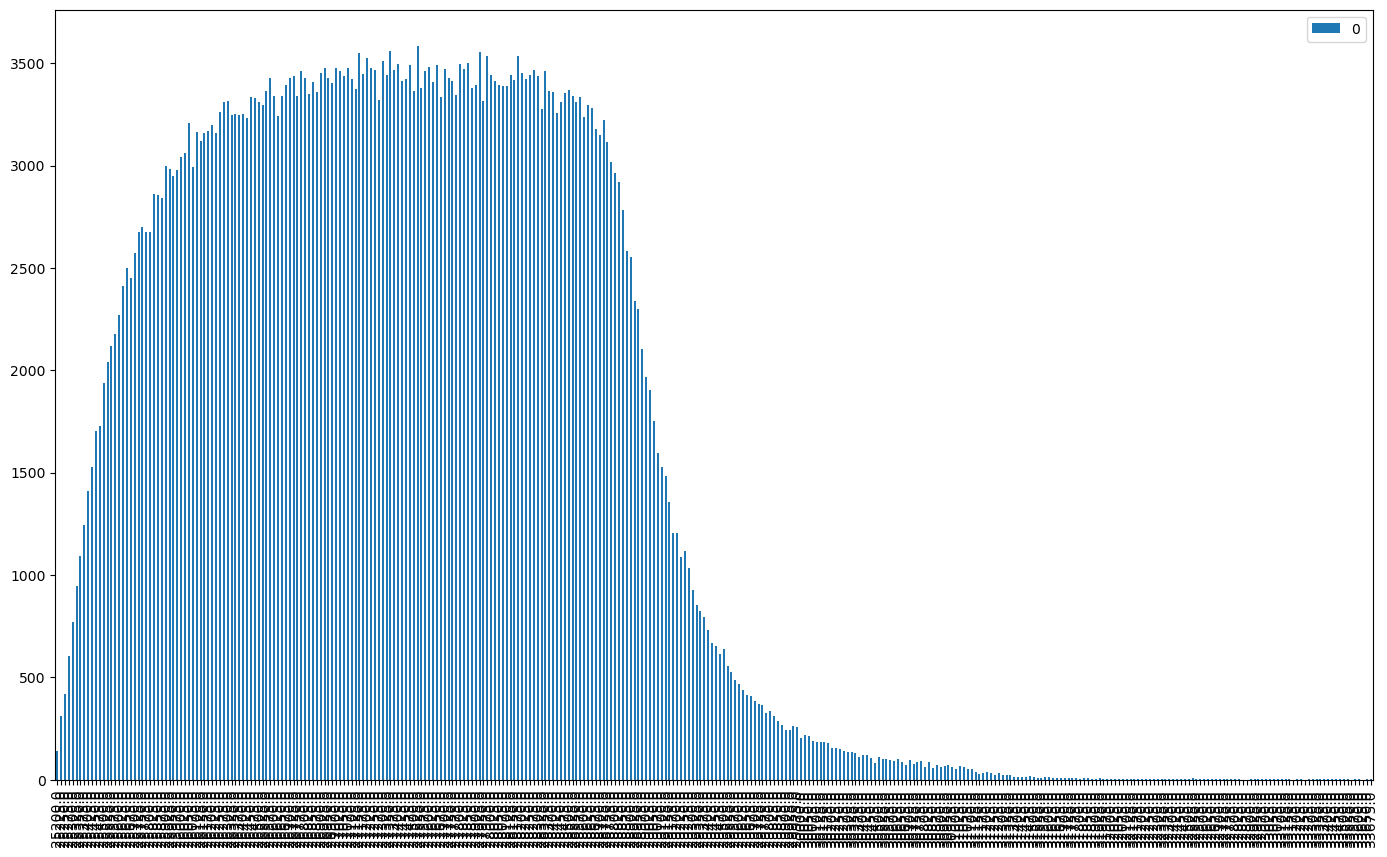

In [ ]:
smallest_time = min(dfpeople['time_departure'])
biggest_time = max(dfpeople['last_time_simulated'])
iterations = 1000
time_interval = 25
print('number of people: ',len(dfpeople),' not considering people that did not leave: ',len(dfpeople[dfpeople['time_departure']!=dfpeople['last_time_simulated']]))
#while((biggest_time-smallest_time)/time_interval>iterations):
#        time_interval += 100
print('bigget - smallest time: ',biggest_time - smallest_time)
print('time interval: ',time_interval)
timeintervals =np.arange(smallest_time, biggest_time, time_interval)
dfpeople = dfpeople[dfpeople['time_departure']!=dfpeople['last_time_simulated']]
interval2npeople = {t:0 for t in timeintervals}
for i,t in enumerate(interval2npeople.keys()):
        if i < len(interval2npeople.keys())-1:
                print('i', i,' time interval: ',t,' ', timeintervals[i+1])
#                t0 = time.time()
#                df_tmp = dfpeople.apply(lambda row: row['time_departure']>t,axis =1)              
                peopleinnet =  dfpeople.apply(lambda row: row['last_time_simulated']>list(interval2npeople.keys())[i] and row['last_time_simulated']<list(interval2npeople.keys())[i+1],axis=1)
#                print(dfpeople.loc[peopleinnet][['time_departure','last_time_simulated']])
#                n,bins = np.histogram((dfpeople.loc[peopleinnet]['last_time_simulated'].to_numpy() - dfpeople.loc[peopleinnet]['time_departure'].to_numpy())/3600,bins = 100)
##                plt.scatter(bins[:-1],n)
 #               plt.xlabel('time length trip')
 #               plt.xscale('log')
 #               plt.title(t)
 #               plt.show()
#                print('number people in net: ',len([1 for p in peopleinnet if True==p]))
#                t1 = time.time()
#                print('time to filter people', t1-t0)        
#        peopleinnet = dfpeople[dfpeople['last_time_simulated']>t]
#        peopleinnet = peopleinnet[peopleinnet['time_departure']<list(interval2npeople.keys())[i+1]]
        interval2npeople[t] = len([1 for p in peopleinnet if True==p])

fig, ax = plt.subplots(1,1, figsize=(17,10))
pd.DataFrame.from_dict(interval2npeople, orient='index').plot(ax = ax,kind='bar')
#plt.plot(bins[:-1], n)

In [ ]:
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
import polars as pl
file_people = "/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_215_UCI_0.141_0_people7to24.csv"
dfpeople = pl.read_csv(file_people,on_bad_lines='skip')#.loc[0]['init_intersection']


def process_chunk(args):
    df_chunk, time_intervals = args
    interval2npeople = {t: 0 for t in time_intervals}
    for i, t in enumerate(interval2npeople.keys()):
        if i < len(interval2npeople.keys()) - 1:
            peopleinnet = df_chunk.apply(lambda row: row['last_time_simulated'] > list(interval2npeople.keys())[i] and row['last_time_simulated'] < list(interval2npeople.keys())[i + 1], axis=1)
            interval2npeople[t] = len([1 for p in peopleinnet if True == p])
    return interval2npeople

def split_dataframe(df, chunk_size):
    chunks = [df.iloc[i:i + chunk_size] for i in range(0, df.shape[0], chunk_size)]
    return chunks

start_control_group = 7*3600
end_control_group = 8*3600
smallest_time = min(dfpeople['time_departure'])
biggest_time = max(dfpeople['last_time_simulated'])
iterations = 1000
time_interval = 30
print('number of people: ', len(dfpeople), ' not considering people that did not leave: ', len(dfpeople[dfpeople['time_departure'] != dfpeople['last_time_simulated']]))
print('biggest - smallest time: ', biggest_time - smallest_time)
print('time interval: ', time_interval)
time_intervals = np.arange(smallest_time, biggest_time, time_interval)
dfpeople = dfpeople[dfpeople['time_departure'] != dfpeople['last_time_simulated']]
dfpeople = dfpeople[dfpeople['time_departure'] > start_control_group]
dfpeople = dfpeople[dfpeople['time_departure'] < end_control_group]
print('number of people in control group: ', len(dfpeople))

# Split the data into chunks
num_chunks = cpu_count()
chunks = split_dataframe(dfpeople, len(dfpeople) // num_chunks)

# Create a pool of workers
with Pool(num_chunks) as pool:
        results = pool.map(process_chunk, [(chunk, time_intervals) for chunk in chunks])

# Combine the results
combined_interval2npeople = {t: 0 for t in time_intervals}
for result in results:
        for t in result:
                combined_interval2npeople[t] += result[t]

#print(combined_interval2npeople)
fig, ax = plt.subplots(1,1, figsize=(17,10))
pd.DataFrame.from_dict(interval2npeople, orient='index').plot(ax = ax,kind='bar')
#plt.plot(bins[:-1], n)

number of people:  7080895  not considering people that did not leave:  7062993
biggest - smallest time:  86399.99508079
time interval:  30


/home/alberto/tmp_alberto/ipykernel_1884077/3591732188.py:34: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  DfPeople = pd.read_csv(file_people,on_bad_lines='skip')#.loc[0]['init_intersection']


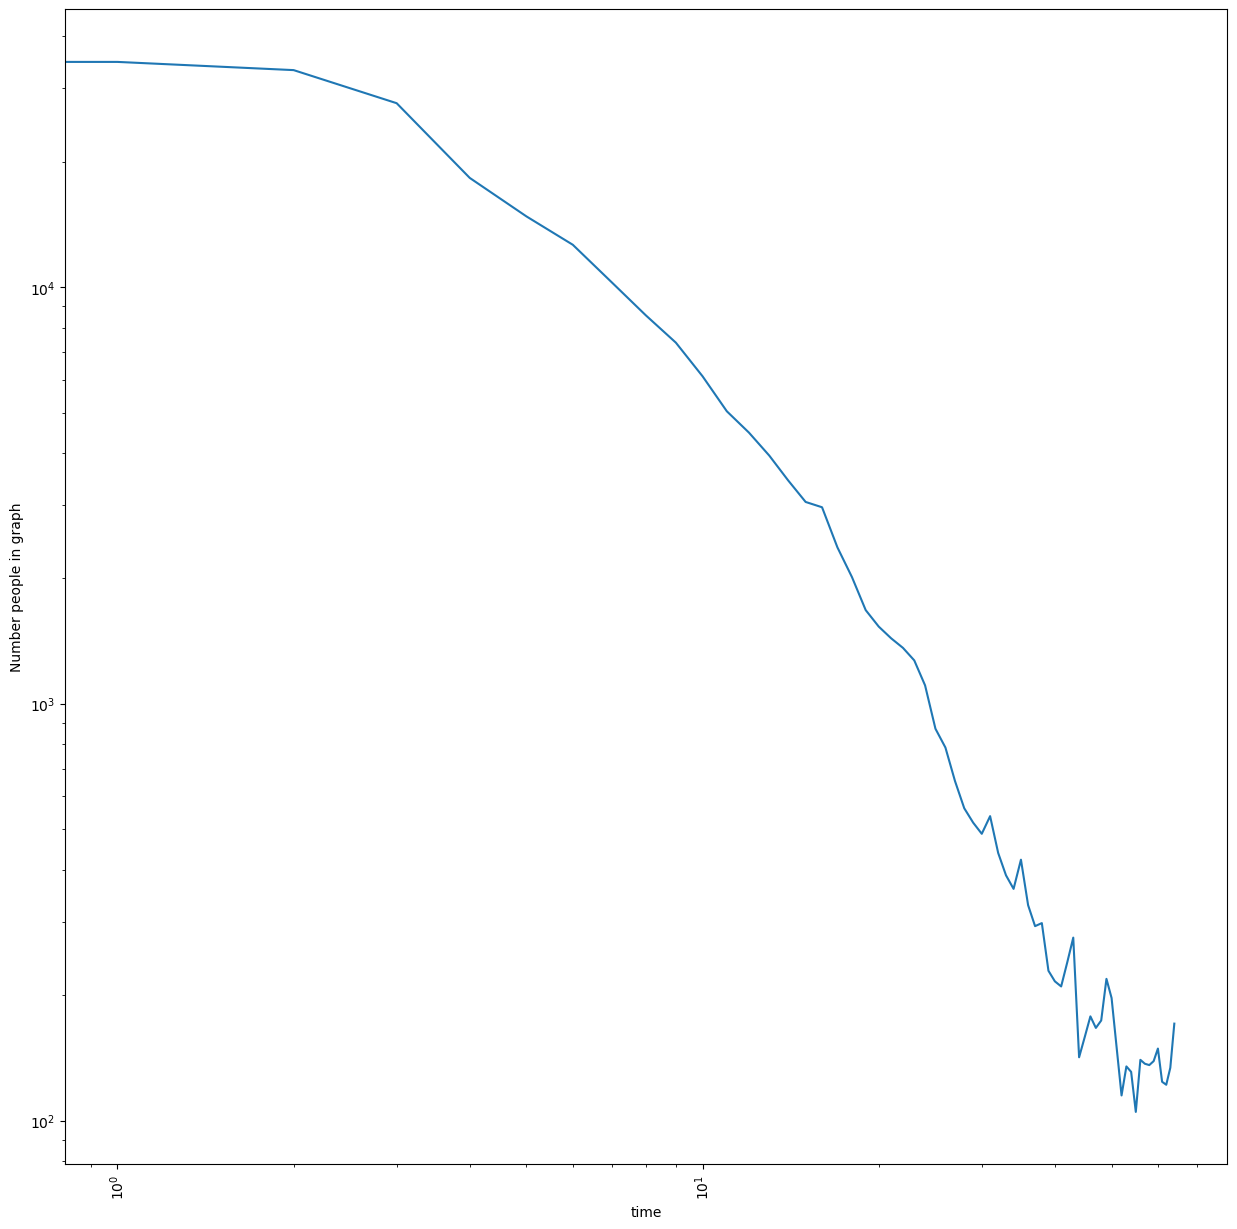

In [ ]:
import polars as pl
from PolarsFunctions import *
from Plots import *
from OutputStats import *
def PlotPeopleInNetwork(Interval2NumberPeopleInNet,interval15,FileName):
    '''
        Input:
            df_people: DataFrame containing the people information (stay time in the network, time of departure, travel time, etc.)
            save_dir: Directory where the plot will be saved
            name: Name of the plot
            hour_in_day: Number of hours in a day
            minutes_in_hour: Number of minutes in an hour
            seconds_in_minute: Number of seconds in a minute
            interval_in_minutes: Number of minutes in each interval
    '''
    fig,ax = plt.subplots(1,1,figsize = (15,15))
    Interval2Plot = [t for t in interval15 if Interval2NumberPeopleInNet[t] > 0]
    NPeople2Count = [Interval2NumberPeopleInNet[t] for t in interval15 if Interval2NumberPeopleInNet[t] > 0]
    ax.plot(Interval2Plot[1:-1],NPeople2Count[1:-1])
#    ax.set_xticks(second2hour(interval15))
#    ax.set_xticklabels([str(t) for t in interval15])
    ax.set_xlabel('time')
    ax.set_ylabel('Number people in graph')
    ax.set_xticks(ticks = interval15[1:-1],labels = interval15[1:-1],rotation=90)
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(FileName,dpi = 200)
    plt.show()


file_people = "/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_215_UCI_0.141_0_people7to24.csv"
PlotDir = "/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/Plots"
R = 215
UCI = 0.141
DfPeople = pd.read_csv(file_people,on_bad_lines='skip')#.loc[0]['init_intersection']
DfPeople = pl.DataFrame(DfPeople[["time_departure","last_time_simulated","p"]])
t0 = 7*3600
t1 = 8*3600
StrTimeDeparture = 'time_departure'
StrLastTimeSimulated = 'last_time_simulated'

SecondsInDay = int(HOURS_IN_DAY*MINUTES_IN_HOUR*SECONDS_IN_MINUTE)
MinutesInDay = int(HOURS_IN_DAY*MINUTES_IN_HOUR)
# I count people in Network at each time interval (15 mins)
NumIntervals = int(MinutesInDay/15)
# Create the Int Time Array (0 -> Seconds In Day)
IntTimeArray = np.linspace(0,TIMESTAMP_OFFSET + SecondsInDay,NumIntervals,dtype = int)       
# Convert it to minutes seconds and hour for the plot Labels (0 -> 24)        
HourTimeArray = ConvertArray2HMS(np.linspace(TIMESTAMP_OFFSET,TIMESTAMP_OFFSET + SecondsInDay,NumIntervals))
Interval2NumberPeopleInNet = {Interval:0 for Interval in HourTimeArray}
ControlGroup = FilterDfPeopleControlGroup(t0,t1,DfPeople,"time_departure","last_time_simulated")
for t in range(len(Interval2NumberPeopleInNet.keys())-1):
    # DataFrame Filtered With People in the Network at time t in the time interval t,t+1
    DfPeopleInNetAtTimet = FilterDfPeopleStilInNet(IntTimeArray[t],IntTimeArray[t+1],"last_time_simulated",ControlGroup)
    # Number Of People in the Network at time t
    Interval2NumberPeopleInNet[HourTimeArray[t]] += len(DfPeopleInNetAtTimet) 
pd.DataFrame(Interval2NumberPeopleInNet.items(),columns = ["Time","NumberPeople"]).to_csv(JoinDir(PlotDir,"UnloadCurve_R_{0}_UCI_{1}.csv".format(R,UCI)),index = False)
PlotPeopleInNetwork(Interval2NumberPeopleInNet,HourTimeArray,os.path.join(PlotDir,"UnloadingCurve_R_{0}_UCI_{1}.png".format(R,UCI)))


In [ ]:
from FittingProcedures import *


int2people = defaultdict(list)
totalpeople = 0
for t in Interval2NumberPeopleInNet.keys():
    if Interval2NumberPeopleInNet[t] != 0 and t>8*3600: 
        int2people[t] = interval2npeople[t]
        totalpeople += interval2npeople[t]
for t in int2people.keys():
    int2people[t] = int2people[t]/totalpeople

time = [t/3600 for t in list(int2people.keys()) if t>8]
plt.scatter(time, list(int2people.values()))
plt.plot(time, (10**90)*np.array(time)**(-100))
plt.xscale('log')
plt.yscale('log')
print(len(time))
print(len(list(int2people.values())))
# FITTING PROCEDURE -> POWER LAW
#initial_guess_powerlaw = (10**90,100)
#fit = Fitting(time, list(int2people.values()), 'powerlaw', initial_guess_powerlaw)
# FITTING PROCEDURE -> EXPONENTIAL
print(list(int2people.values())[0])
initial_guess_expo = ((list(int2people.values())[0]),10)
fitexp = Fitting(time, list(int2people.values()), 'exponential', initial_guess_expo)
# PLOTTING PROCEDURE
#fig,ax = plt.subplots(2,1,figsize=(10,10))
#ax[0].scatter(time, int2people.values())
#ax[0].plot(time, powerlaw(time, fit[0][0], fit[0][1]), color='red')
#ax[0].set_xlabel('time')
#ax[0].set_ylabel('number of people in graph')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_title('${0}x^{1}$'.format(round(fit[0][0],2), round(fit[0][1],2)))
#ax[1].scatter(time, int2people.values())
#ax[1].plot(time, exponential(time, fitexp[0][0], fitexp[0][1]), color='red')
#ax[1].set_xlabel('time')
#ax[1].set_ylabel('number of people in graph')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_title('${0}exp^{1}$'.format(round(fitexp[0][0],2), round(fitexp[0][1],2)))
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(time, int2people.values())
ax.plot(time,fitexp[0][0] + fitexp[0][0]* np.exp(-np.array(time)*fitexp[0][1]), color='red')
ax.set_xlabel('time')
ax.set_ylabel('number of people in graph')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('${0}exp(-t/{1})$'.format(round(fitexp[0][0],2), round(fitexp[0][1],2)))

plt.show()

['00:00:00',
 '00:15:09',
 '00:30:18',
 '00:45:28',
 '01:00:37',
 '01:15:47',
 '01:30:56',
 '01:46:06',
 '02:01:15',
 '02:16:25',
 '02:31:34',
 '02:46:44',
 '03:01:53',
 '03:17:03',
 '03:32:12',
 '03:47:22',
 '04:02:31',
 '04:17:41',
 '04:32:50',
 '04:48:00',
 '05:03:09',
 '05:18:18',
 '05:33:28',
 '05:48:37',
 '06:03:47',
 '06:18:56',
 '06:34:06',
 '06:49:15',
 '07:04:25',
 '07:19:34',
 '07:34:44',
 '07:49:53',
 '08:05:03',
 '08:20:12',
 '08:35:22',
 '08:50:31',
 '09:05:41',
 '09:20:50',
 '09:36:00',
 '09:51:09',
 '10:06:18',
 '10:21:28',
 '10:36:37',
 '10:51:47',
 '11:06:56',
 '11:22:06',
 '11:37:15',
 '11:52:25',
 '12:07:34',
 '12:22:44',
 '12:37:53',
 '12:53:03',
 '13:08:12',
 '13:23:22',
 '13:38:31',
 '13:53:41',
 '14:08:50',
 '14:24:00',
 '14:39:09',
 '14:54:18',
 '15:09:28',
 '15:24:37',
 '15:39:47',
 '15:54:56',
 '16:10:06',
 '16:25:15',
 '16:40:25',
 '16:55:34',
 '17:10:44',
 '17:25:53',
 '17:41:03',
 '17:56:12',
 '18:11:22',
 '18:26:31',
 '18:41:41',
 '18:56:50',
 '19:12:00',

# n(t) FIT

189
189
0.0539163189187193
Fitting exponential
(array([ 0.05391632, 10.        ]), array([[inf, inf],
       [inf, inf]]))
expo fit:  0.0539163189187193   10.0
Convergence fit expo:  True
Optimal parameters:  [ 0.05391632 10.        ]
Message:  Optimization terminated successfully.


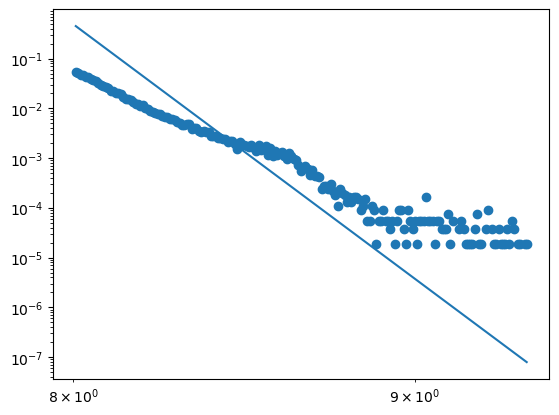

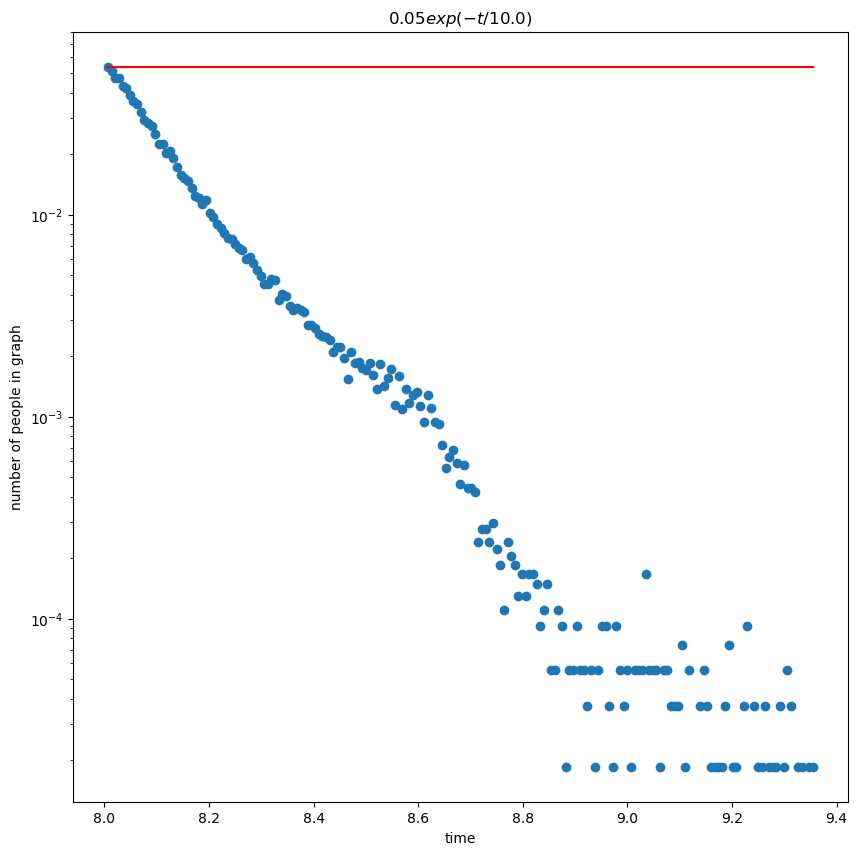

In [ ]:
from FittingProcedures import *


int2people = defaultdict(list)
totalpeople = 0
for t in interval2npeople.keys():
    if interval2npeople[t] != 0 and t>8*3600: 
        int2people[t] = interval2npeople[t]
        totalpeople += interval2npeople[t]
for t in int2people.keys():
    int2people[t] = int2people[t]/totalpeople

time = [t/3600 for t in list(int2people.keys()) if t>8]
plt.scatter(time, list(int2people.values()))
plt.plot(time, (10**90)*np.array(time)**(-100))
plt.xscale('log')
plt.yscale('log')
print(len(time))
print(len(list(int2people.values())))
# FITTING PROCEDURE -> POWER LAW
#initial_guess_powerlaw = (10**90,100)
#fit = Fitting(time, list(int2people.values()), 'powerlaw', initial_guess_powerlaw)
# FITTING PROCEDURE -> EXPONENTIAL
print(list(int2people.values())[0])
initial_guess_expo = ((list(int2people.values())[0]),10)
fitexp = Fitting(time, list(int2people.values()), 'exponential', initial_guess_expo)
# PLOTTING PROCEDURE
#fig,ax = plt.subplots(2,1,figsize=(10,10))
#ax[0].scatter(time, int2people.values())
#ax[0].plot(time, powerlaw(time, fit[0][0], fit[0][1]), color='red')
#ax[0].set_xlabel('time')
#ax[0].set_ylabel('number of people in graph')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_title('${0}x^{1}$'.format(round(fit[0][0],2), round(fit[0][1],2)))
#ax[1].scatter(time, int2people.values())
#ax[1].plot(time, exponential(time, fitexp[0][0], fitexp[0][1]), color='red')
#ax[1].set_xlabel('time')
#ax[1].set_ylabel('number of people in graph')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_title('${0}exp^{1}$'.format(round(fitexp[0][0],2), round(fitexp[0][1],2)))
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(time, int2people.values())
ax.plot(time,fitexp[0][0] + fitexp[0][0]* np.exp(-np.array(time)*fitexp[0][1]), color='red')
ax.set_xlabel('time')
ax.set_ylabel('number of people in graph')
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('${0}exp(-t/{1})$'.format(round(fitexp[0][0],2), round(fitexp[0][1],2)))

plt.show()

# INSERTION CURVE

518256


(array([64407., 16885., 18260., 21687., 19270., 22397., 25636., 18720.,
        17291., 29823., 18304., 24568., 18640., 28198., 15801., 20399.,
        22051., 18746., 20593., 19653., 17415., 15852., 14838.,  8822.]),
 array([7.        , 7.04158102, 7.08316204, 7.12474306, 7.16632407,
        7.20790509, 7.24948611, 7.29106713, 7.33264815, 7.37422917,
        7.41581019, 7.4573912 , 7.49897222, 7.54055324, 7.58213426,
        7.62371528, 7.6652963 , 7.70687731, 7.74845833, 7.79003935,
        7.83162037, 7.87320139, 7.91478241, 7.95636343, 7.99794444]),
 <BarContainer object of 24 artists>)

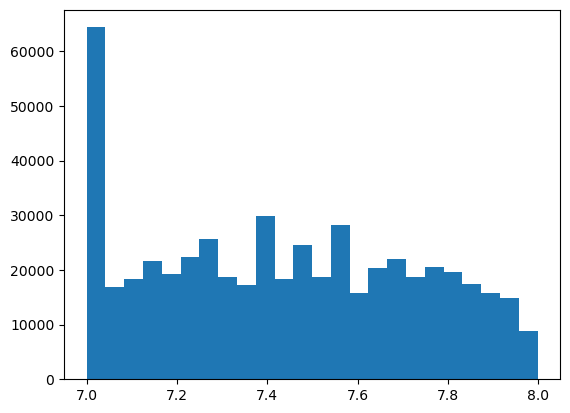

In [ ]:
print(len(dfpeople))
time_dep = dfpeople['time_departure'].to_numpy()/3600
plt.hist(time_dep , bins = 24)

# TIME LENGTH DISTRIBUTION

Fitting powerlaw
(array([1.29730786e+04, 1.80197255e-08]), array([[2.24446821e+06, 4.49107865e+01],
       [4.49107865e+01, 1.23836345e-02]]))
powerlaw fit:  12973.07856981606   1.8019725533262172e-08
Convergence fit powerlaw:  False
Optimal parameters:  [1.31824804e+04 1.50764652e-02]
Message:  Desired error not necessarily achieved due to precision loss.


/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in power
  return amp * (np.array(x)**index)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in power
  return amp * (np.array(x)**index)
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in power
  return amp * (np.array(x)**index)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in po

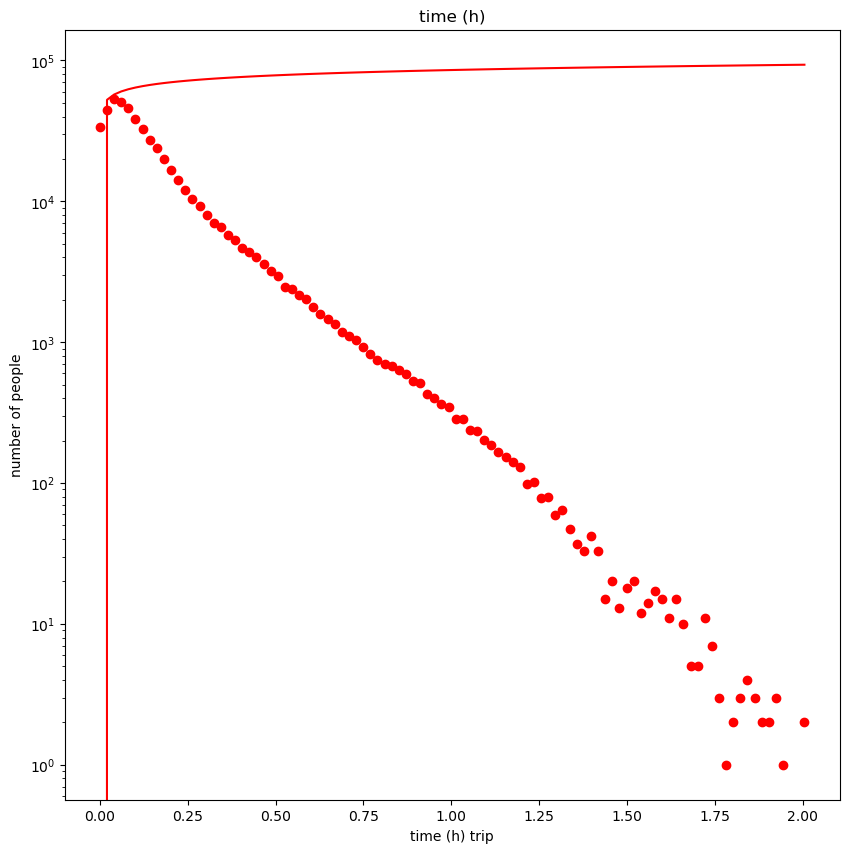

12973.07856981606 1.8019725533262172e-08
Fitting exponential
(array([5.38538598e+04, 5.22735841e+00]), array([[3.15995655e+06, 3.05583869e+02],
       [3.05583869e+02, 6.60697479e-02]]))
expo fit:  53853.85976245388   5.227358413620664
Convergence fit expo:  False
Optimal parameters:  [5.38531999e+04 5.22730877e+00]
Message:  Desired error not necessarily achieved due to precision loss.


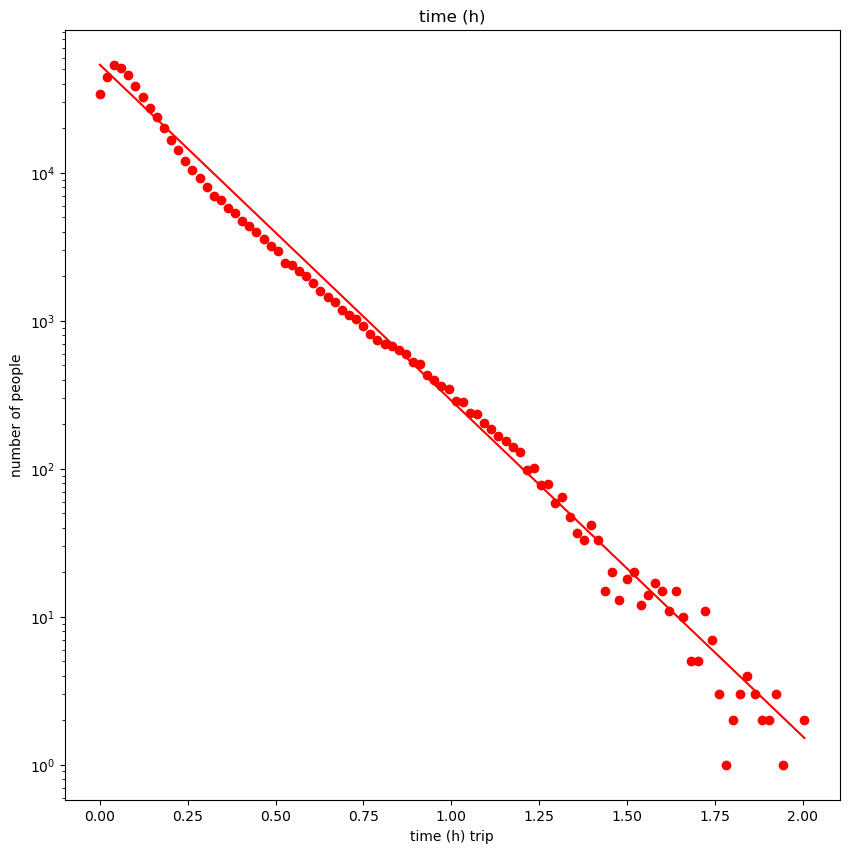

Fitting powerlaw
(array([2.29327362e+03, 2.50949024e-08]), array([[ 3.36543672e+07, -3.43280389e+03],
       [-3.43280389e+03,  3.76950754e-01]]))
powerlaw fit:  2293.2736150366723   2.509490236931278e-08
Convergence fit powerlaw:  False
Optimal parameters:  [1.34286993e+03 3.11491568e-03]
Message:  Desired error not necessarily achieved due to precision loss.


/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in power
  return amp * (np.array(x)**index)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in power
  return amp * (np.array(x)**index)
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in power
  return amp * (np.array(x)**index)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:8: RuntimeWarning: divide by zero encountered in po

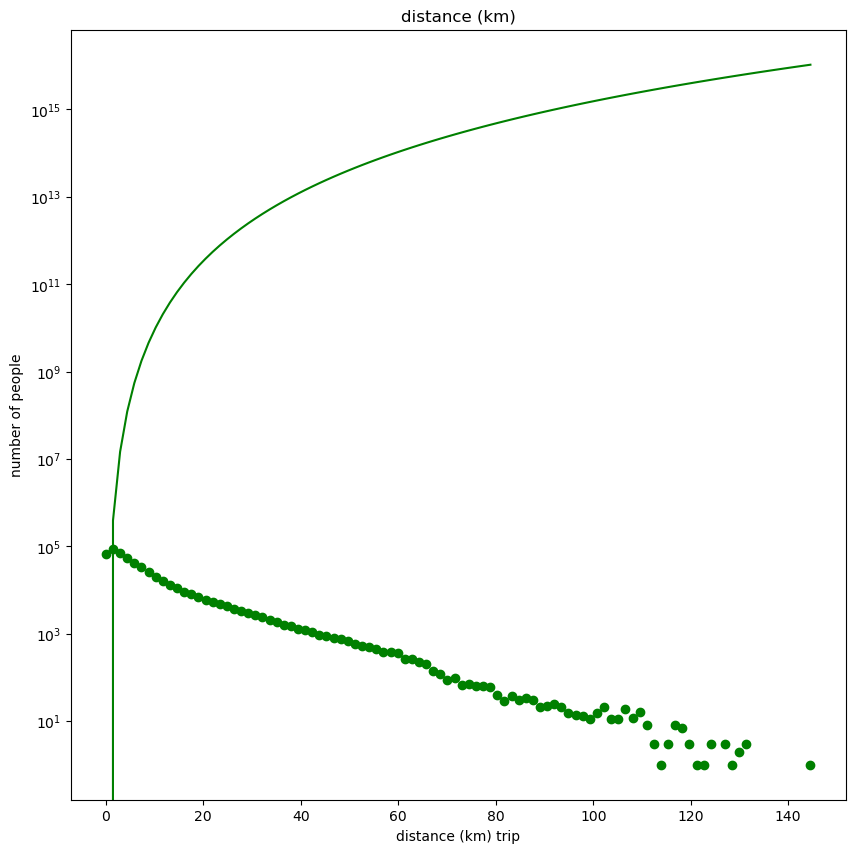

Fitting exponential
(array([8.54991289e+04, 1.24918492e-01]), array([[4.48591404e+06, 6.48247480e+00],
       [6.48247480e+00, 2.28590971e-05]]))
expo fit:  85499.12887484649   0.1249184915491817
Convergence fit expo:  False
Optimal parameters:  [8.54969326e+04 1.24916410e-01]
Message:  Desired error not necessarily achieved due to precision loss.


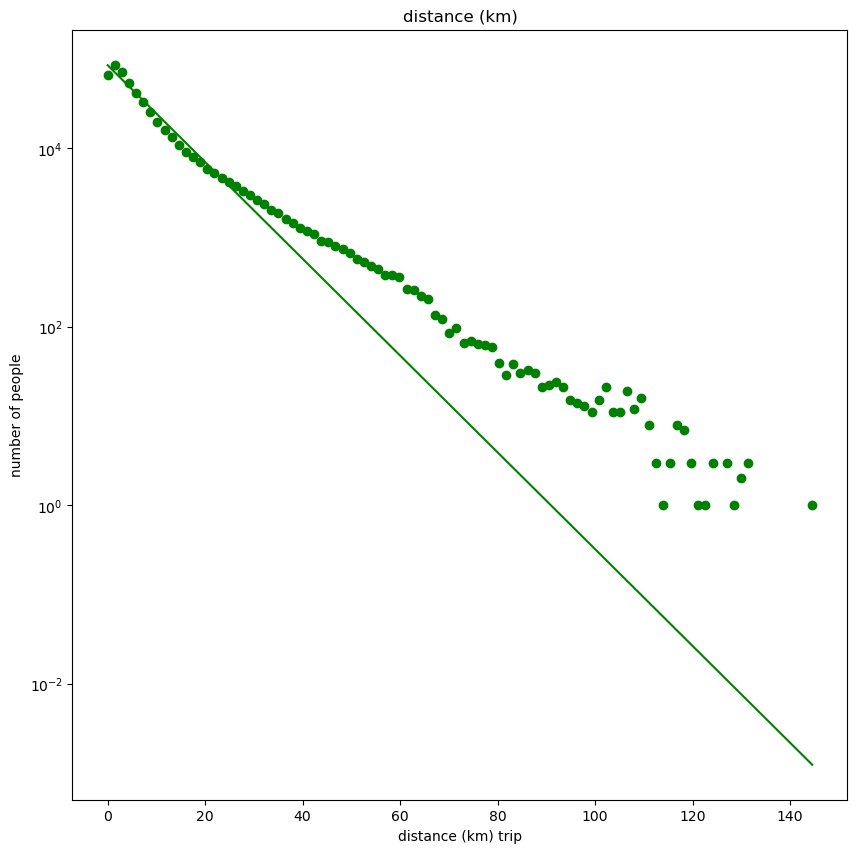

Fitting powerlaw
(array([4.27902783e+03, 6.71964559e-02]), array([[ 4.72371514e+06, -3.65939221e+02],
       [-3.65939221e+02,  3.05935748e-02]]))
powerlaw fit:  4279.027830098895   0.06719645593159818
Convergence fit powerlaw:  False
Optimal parameters:  [4.27663955e+03 6.73798690e-02]
Message:  Desired error not necessarily achieved due to precision loss.


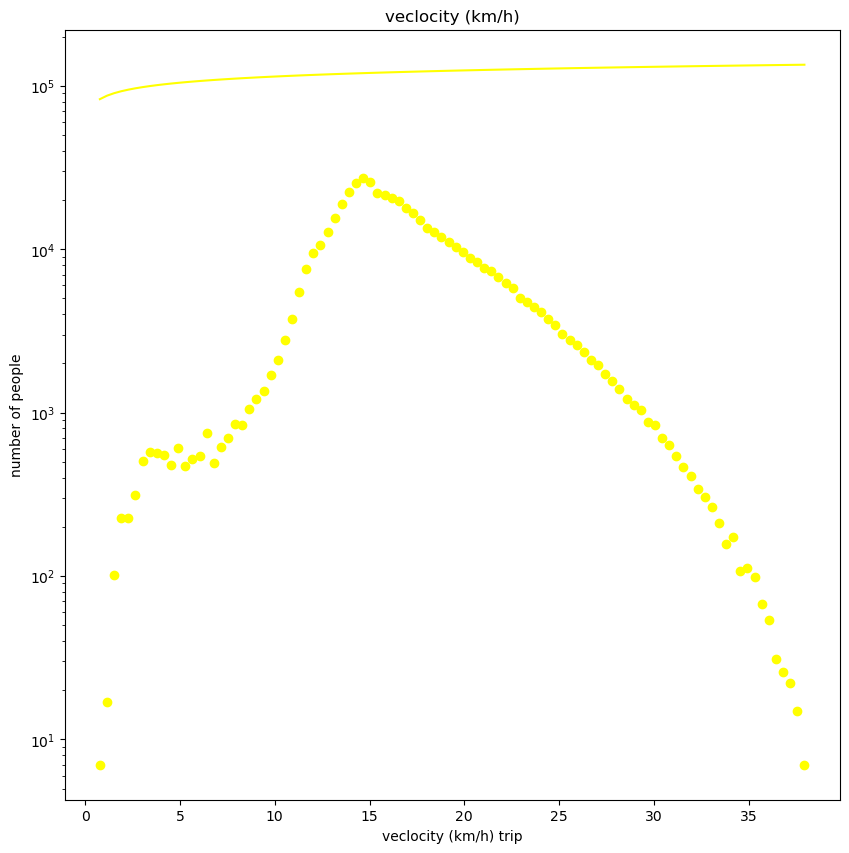

Fitting exponential
(array([6.40078551e+03, 1.14674154e-02]), array([[2.59809002e+06, 1.72922519e+01],
       [1.72922519e+01, 1.61789931e-04]]))
expo fit:  6400.785511973564   0.011467415403769936
Convergence fit expo:  False
Optimal parameters:  [ 7.00576572 -0.14742001]
Message:  Desired error not necessarily achieved due to precision loss.


/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:11: RuntimeWarning: overflow encountered in exp
  return amp * np.exp(-index*np.array(x))
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:14: RuntimeWarning: overflow encountered in square
  return np.sum((y_predict-y_measured)**2)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:11: RuntimeWarning: overflow encountered in exp
  return amp * np.exp(-index*np.array(x))
/home/aamad/Desktop/phd/berkeley/traffic_phase_transition/scripts/FittingProcedures.py:14: RuntimeWarning: overflow encountered in square
  return np.sum((y_predict-y_measured)**2)


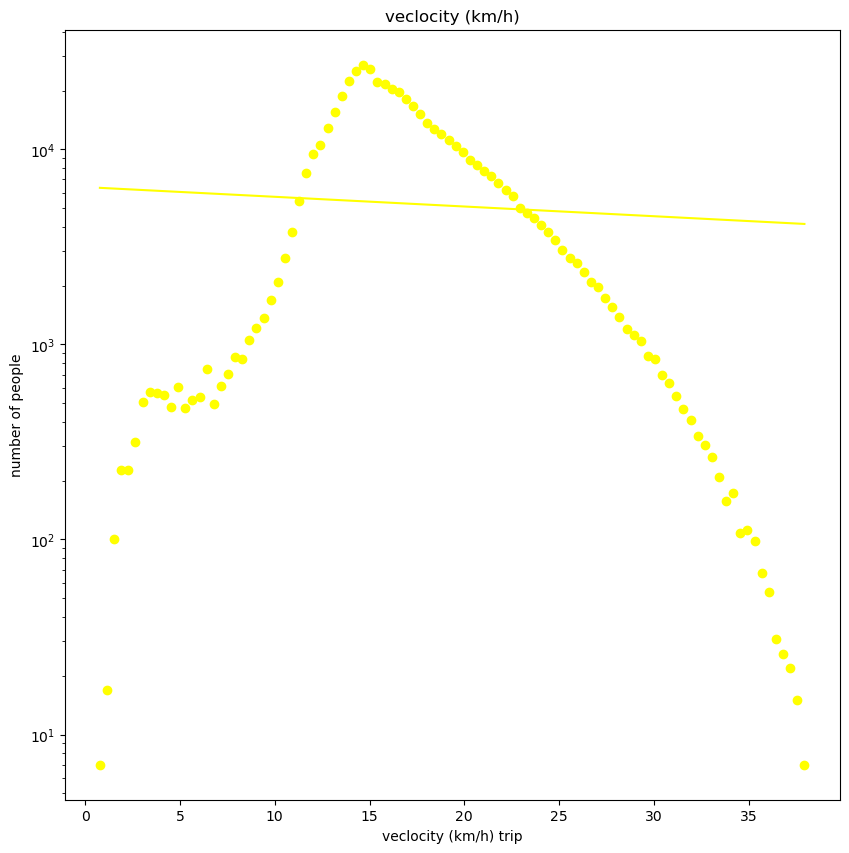

'Expected that there is a peak between 7 and 8 am. All the other bins should be empty.'

In [ ]:
from FittingProcedures import *
feature2color = {'time (h)':'red','distance (km)':'green','veclocity (km/h)':'yellow'}
def PlotDistributionFeatureTrajFit(bins,n,fit,feature2color,feature,FittingFunction):
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    if FittingFunction == 'powerlaw':
        ax.scatter(bins[:-1], n,color = feature2color[feature])
        ax.plot(bins[:-1], powerlaw(bins[:-1], fit[0][0], fit[0][1]), color = feature2color[feature])
        ax.set_xlabel('{} trip'.format(feature))
        ax.set_ylabel('number of people')
#        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('{}'.format(feature))
    if FittingFunction == 'exponential':
        ax.scatter(bins[:-1], n,color = feature2color[feature])
        ax.plot(bins[:-1], exponential(bins[:-1], fit[0][0], fit[0][1]), color = feature2color[feature])
        ax.set_xlabel('{} trip'.format(feature))
        ax.set_ylabel('number of people')
#        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('{}'.format(feature))
    plt.show()    

#file = '/home/aamad/Desktop/phd/berkeley/data/carto/BOS/od_demand_7to8_R_162.csv'
#dfOD = pd.read_csv(file)
#print(dfOD)
# TIME
n,bins = np.histogram(dfpeople['last_time_simulated'].to_numpy()/3600 - dfpeople['time_departure'].to_numpy()/3600,bins = 100)
initial_guess_powerlaw = (40000,0.3) 
fitpl = Fitting(bins[:-1], n,'powerlaw', initial_guess_powerlaw)
PlotDistributionFeatureTrajFit(bins,n,fitexp,feature2color,'time (h)','powerlaw')
print(fitpl[0][0], fitpl[0][1])
initial_guess_expo = (n[0],0.3)
fitexp = Fitting(bins[:-1], n,'exponential', initial_guess_expo)
PlotDistributionFeatureTrajFit(bins,n,fitexp,feature2color,'time (h)','exponential')
# DISTANCE 
n,bins = np.histogram(dfpeople['distance'].to_numpy()/1000,bins = 100)
initial_guess_powerlaw = (40000,0.3) 
fitpl = Fitting(bins[:-1], n,'powerlaw', initial_guess_powerlaw)
PlotDistributionFeatureTrajFit(bins,n,fitexp,feature2color,'distance (km)','powerlaw')
initial_guess_expo = (n[0],0.3)
fitexp = Fitting(bins[:-1], n,'exponential', initial_guess_expo)
PlotDistributionFeatureTrajFit(bins,n,fitexp,feature2color,'distance (km)','exponential')
# VELOCITY

n,bins = np.histogram(dfpeople['avg_v(mph)'].dropna().to_numpy()/1.6,bins = 100)
initial_guess_powerlaw = (40000,0.3) 
fitpl = Fitting(bins[:-1], n,'powerlaw', initial_guess_powerlaw)
PlotDistributionFeatureTrajFit(bins,n,fitexp,feature2color,'veclocity (km/h)','powerlaw')
initial_guess_expo = (n[0],0.3)
fitexp = Fitting(bins[:-1], n,'exponential', initial_guess_expo)
PlotDistributionFeatureTrajFit(bins,n,fitexp,feature2color,'veclocity (km/h)','exponential')



'''Expected that there is a peak between 7 and 8 am. All the other bins should be empty.'''


# EXPECTED TIME DISTRIBUTION WITHOUT TRAFFIC

In [ ]:
edges

,uniqueid,u,v,length,speed_mph,lanes,osmid_u,osmid_v
0,0,0,9,51.8,35,1,61816807,61819222
1,1,0,3,55.4,25,1,61816807,61817409
2,2,0,6,2223.4,35,1,61816807,61818775
3,3,1,10,1116.2,35,1,61817002,61819564
4,4,1,9,30.0,35,1,61817002,61819222
...,...,...,...,...,...,...,...,...
54946,54946,23464,23463,15.6,20,1,10281222833,10281222831
54947,54947,23465,23463,105.5,20,1,10281222839,10281222831
54948,54948,23466,23186,16.9,25,1,10844948681,72474574
54949,54949,23466,23165,95.0,50,1,10844948681,72330377


In [ ]:
from multiprocessing import Pool
def read_peoplefile(filename):
    df = pd.read_csv(filename)
    return df
cartographml = '/home/aamad/Desktop/phd/berkeley/data/carto/BOS/BOS_new_tertiary_simplified.graphml'
file_routes = '/home/aamad/Desktop/phd/berkeley/data/BOS/R_1/0_route7to24.csv'
file_people = '/home/aamad/Desktop/phd/berkeley/data/BOS/R_1/0_people7to24.csv'

def ComputeTimeRoadWithoutTraffic(row):
    '''
        Computes the time it would take to go from point A to B without traffic.
        Is to be used with aplly in the edges dataframe.
    '''
    if 'speed_mph' in row.keys() and 'length' in row.keys():
        if not np.isnan(row['speed_mph']) and not np.isnan(row['length']):
            return row['length']/(row['speed_mph']/1.6)/1000
        else:
            row['length']/50/1000
    else:
        raise ValueError('speed_mph or length not in row.keys(): CHANGE DATAFRAME')
    
def IfInList(row,list_):
    return row['uniqueid'] in list_
class PersonMobility:
    def __init__(self,
                 id,
                 start_point,
                 traj,
                 end_point,
                 distance_traveled,
                 time_departure,
                 last_time,
                 av_vmph):
        self.id = id
        self.traj = [start_point]
        self.traj.extend(traj)
        self.traj.append(end_point)
        self.distance_traveled = distance_traveled
        self.time_departure = time_departure
        self.last_time = last_time
        self.av_vkmh = av_vmph/1.66
        pass

    def ComputeEstimatedTimeOnGraph(self, edges):
        '''
            Computes how much time the traveller would need to go from place A to B if each edge it travels is at the max speed
        '''
        time = 0
        edges['time_without_traffic'] = edges.apply(ComputeTimeRoadWithoutTraffic, axis=1)    
        if len(self.traj) == len(np.unique(self.traj)):
            time = np.sum(edges[edges['uniqueid'].isin(self.traj)]['time_without_traffic']) 
        else:
            edges['count_traj'] = edges['uniqueid'].apply(lambda x: self.traj.count(x))
            time  = np.sum(edges[edges['uniqueid'].isin(self.traj)].apply(lambda row: row['time_without_traffic']*row['count_traj']))                 
        self.EstimatedTimeOnGraph = time

class RouteMobility:
    def __init__(self,lines):
        return

def ParallelizeTimeOnGraph(Id2PeopleMobility,id_):
    ''' '''
    Id2PeopleMobility[id_].ComputeEstimatedTimeOnGraph(edges)

with open(file_routes, 'r') as f:
    lines = f.readlines()[1:]
dfpeople = read_peoplefile(file_people)
Id2PeopleMobility = defaultdict(list)
TotalTimeInNetPerPerson = []

ids = []
for line in lines:
    ll = line.split(':')
    Id2PeopleMobility[ll[0]] = PersonMobility(ll[0],
                                            dfpeople.iloc[int(ll[0])]['init_intersection'],
                                            ast.literal_eval(ll[1]), 
                                            dfpeople.iloc[int(ll[0])]['end_intersection'],
                                            ll[2], 
                                            dfpeople.iloc[int(ll[0])]['time_departure'],
                                            dfpeople.iloc[int(ll[0])]['last_time_simulated'],
                                            dfpeople.iloc[int(ll[0])]['avg_v(mph)']
                                            )     
    ids.append(ll[0])
    if int(ll[0])%1000 == 0:
        print('person ', ll[0], ' done')

arguments = [(Id2PeopleMobility,id_) for id_ in ids]
with Pool() as pool:
# Map the function to the arguments in parallel
    results = pool.starmap(ParallelizeTimeOnGraph, arguments)

TotalTimeInNetPerPerson = [Id2PeopleMobility[id_].EstimatedTimeOnGraph for id_ in ids]

#ParallelizeTimeOnGraph(Id2PeopleMobility,id_)
n,bins = np.histogram(dfpeople['last_time_simulated'].to_numpy()/3600 - dfpeople['time_departure'].to_numpy()/3600,bins = 100)
initial_guess_expo = (n[0],0.3)
fitexp = Fitting(bins[:-1], n,'exponential', initial_guess_expo)
n1,bins1 = np.histogram(TotalTimeInNetPerPerson,bins = 100)
initial_guess_expo = (n1[0],0.3)
fitexp1 = Fitting(bins1[:-1], n1,'exponential', initial_guess_expo)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(bins[:-1], n,color = 'red')
ax.scatter(bins1[:-1], n1,color = 'blue')
ax.plot(bins[:-1], exponential(bins[:-1], fitexp[0][0], fitexp[0][1]), color='red')
ax.plot(bins1[:-1], exponential(bins1[:-1], fitexp1[0][0], fitexp1[0][1]), color='blue')
ax.set_xlabel('time trip')
ax.set_ylabel('number of people')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(['Simulation','Estimated without traffic'])
plt.show()





person  0  done
person  1000  done
person  2000  done
person  3000  done
person  4000  done
person  5000  done
person  6000  done
person  7000  done
person  8000  done
person  9000  done
person  10000  done
person  11000  done
person  12000  done
person  13000  done
person  14000  done
person  15000  done
person  16000  done
person  17000  done
person  18000  done
person  19000  done
person  20000  done
person  21000  done
person  22000  done
person  23000  done
person  24000  done
person  25000  done
person  26000  done
person  27000  done
person  28000  done
person  29000  done
person  30000  done
person  31000  done
person  32000  done
person  33000  done
person  34000  done
person  35000  done
person  36000  done
person  37000  done
person  38000  done
person  39000  done
person  40000  done
person  41000  done
person  42000  done
person  43000  done
person  44000  done
person  45000  done
person  46000  done
person  47000  done
person  48000  done
person  49000  done
person  50000

/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/aamad/anaconda3/envs/gt/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axi

KeyboardInterrupt: 

In [ ]:
TotalTimeInNetPerPerson = [Id2PeopleMobility[id_].EstimatedTimeOnGraph for id_ in ids]

#ParallelizeTimeOnGraph(Id2PeopleMobility,id_)
n,bins = np.histogram(dfpeople['last_time_simulated'].to_numpy()/3600 - dfpeople['time_departure'].to_numpy()/3600,bins = 100)
initial_guess_expo = (n[0],0.3)
fitexp = Fitting(bins[:-1], n,'exponential', initial_guess_expo)
n1,bins1 = np.histogram(TotalTimeInNetPerPerson,bins = 100)
initial_guess_expo = (n1[0],0.3)
fitexp1 = Fitting(bins1[:-1], n1,'exponential', initial_guess_expo)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(bins[:-1], n,color = 'red')
ax.scatter(bins1[:-1], n1,color = 'blue')
ax.plot(bins[:-1], exponential(bins[:-1], fitexp[0][0], fitexp[0][1]), color='red')
ax.plot(bins1[:-1], exponential(bins1[:-1], fitexp1[0][0], fitexp1[0][1]), color='blue')
ax.set_xlabel('time trip')
ax.set_ylabel('number of people')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(['Simulation','Estimated without traffic'])
plt.show()


# Phase Transition Analysis

In [ ]:
import os
import osmnx as ox
import json
from multiple_launches import RsUCIsFromDir,HOME_DIR
from OutputStats import OutputStats
from TrajectoryAnalysis import Polycentrism2TrafficAnalyzer
from GenerateConfiguraiton import GenerateConfig,InitConfigPolycentrismAnalysis,SelectUCIsIfAllR
from PhaseTransition import *
from Plots import *
TRAFFIC_DIR = os.environ['TRAFFIC_DIR']
BaseConfig = os.path.join(os.environ["TRAFFIC_DIR"],"config")
CityNames = ['BOS']#['BOS','LAX','SFO','RIO','LIS']
verbose = True
City2Config = InitConfigPolycentrismAnalysis(CityNames)
for CityName in CityNames:
    print(City2Config)
    print(type(City2Config))
    with open(os.path.join(BaseConfig,'post_processing_' + CityName +'.json'),'w') as f:
        json.dump(City2Config[CityName],f,indent=4)
    # Directories
    BaseOutputDir = os.path.join(HOME_DIR,'berkeley_2018',CityName,'Output')
    PlotDir = os.path.join(BaseOutputDir,'Plots')
    OD_dir = os.path.join(HOME_DIR,'berkeley_2018',"new_full_network")
    cartography = ox.load_graphml(filepath=os.path.join(os.environ["TRAFFIC_DIR"],"data","carto",CityName,f'{CityName}_new_tertiary_simplified.graphml'))
    # NOTE: Extracting the same UCIs and Rs of multiple_launches.py -> In 
    Rs,UCIs = RsUCIsFromDir(OD_dir)
    UCIs = SelectUCIsIfAllR(Rs,UCIs,OD_dir)
    PlotAvailableUCIs(UCIs,PlotDir)
    print(f"Total Number Simulation {CityName}: ",len(UCIs))
    PCTA = Polycentrism2TrafficAnalyzer(City2Config[CityName])  
    for UCI in UCIs:
        UCI = float(UCI)
        if UCI not in PCTA.UCI2R2Time2PeopleInNet.keys():
            PCTA.UCI2R2Time2PeopleInNet[UCI] = {}
            PCTA.UCI2R2ErrorFit[UCI] = {}
            PCTA.UCI2R2Tau[UCI] = {}
        for R in Rs:
            R = int(R)
            if R not in PCTA.UCI2R2Time2PeopleInNet[UCI].keys():
                PCTA.UCI2R2Time2PeopleInNet[UCI][R] = {}
                PCTA.UCI2R2ErrorFit[UCI][R] = {}
                PCTA.UCI2R2Tau[UCI][R] = None    
            if R in City2Config[CityName][UCI].keys():        
                OS = OutputStats(R,UCI,City2Config[CityName],PCTA.GeoJsonEdges)
                OS.ComputeUnloadCurve()
            if 0 == 1:
                # NOTE:we are saving the variables for the phase transition plot -> At the end of these loops we will have all the fitting parameters and errors to plot alpha and beta
                PCTA.UCI2R2Time2PeopleInNet[UCI][R] = OS.Interval2NumberPeopleInNet
                PCTA.UCI2R2ErrorFit[UCI][R], PCTA.UCI2R2Tau[UCI][R] = ComputeAlpha(OS.Interval2NumberPeopleInNet)
                # Plot to Check 
                t = np.array(PCTA.UCI2R2Time2PeopleInNet[UCI][R].keys())
                Nt = np.array([PCTA.UCI2R2Time2PeopleInNet[UCI][R][t_] for t_ in t])
                Nt = Nt/np.sum(Nt)
                PlotNtAndFitSingleR(t,Nt,PCTA.UCI2R2Tau[UCI][R],R,UCI,PlotDir)
                PlotErrorFitAlphaWindow(PCTA.UCI2R2ErrorFit[UCI][R],R,UCI,PlotDir)
    for UCI in PCTA.UCI2R2Time2PeopleInNet.keys():
        # Saving the Phase transition Order parameter for the couple of pairs (UCI,R)
        PCTA.UCI2NR[UCI] = np.array(OS.Interval2NumberPeopleInNet.values())[PCTA.UCI2R2Tau[UCI][R]]
        for R in PCTA.UCI2R2Time2PeopleInNet[UCI].keys():
            pass

In [ ]:
import pandas as pd
# 
df = pd.read_csv("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_route7to24.csv",delimiter=':')
print(df.head())
print(df.info())
df.to_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_route7to24.parquet",engine='pyarrow')
df = pd.read_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_route7to24.parquet",engine='pyarrow')
print(df.head())
print(df.info())
df.to_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_route7to24.snappy.parquet",engine='pyarrow',compression = 'snappy')
df = pd.read_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_route7to24.snappy.parquet",engine='pyarrow')
print(df.head())
print(df.info())



In [ ]:
import os
import pandas as pd
from multiprocessing import Pool

directory = "/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output"

def AllFiles2Parquet(file_path):
    if "parquet" not in file_path and "Plots" not in file_path and "Monocentric" not in file_path and "json" not in file_path:
        if "route" in file_path:
            df = pd.read_csv(file_path, delimiter=':')
        else:
            df = pd.read_csv(file_path)
        file_new = file_path.replace('.csv', '.parquet')
        df.to_parquet(file_new, engine='pyarrow', compression='snappy')
        os.remove(file_path)
    else:
        pass

def process_directory(directory):
    files = [os.path.join(directory, file) for file in os.listdir(directory)]
    return files

# Get the list of files to process
files = process_directory(directory)

# Use Pool to process files in parallel
with Pool(15) as p:
    p.map(AllFiles2Parquet, files)

# Reconstructing Traffic Patterns

# UPLOAD

In [1]:
import polars as pl
import pandas as pd
from GeoJsonFunctions import *
from PolarsFunctions import *
import json
dtypes = {"p":pl.Int64,
            "init_intersection":pl.Int64,
            "end_intersection":pl.Int64,
            "time_departure":pl.Float64,
            "num_steps":pl.Int64,
            "co":pl.Float32,
            "gas":pl.Float32,
            "distance":pl.Float32,
            "a":pl.Float32,
            "b":pl.Float32,
            "T":pl.Float32,"avg_v(mph)":pl.Float32,
            "active":pl.Int32,
            "last_time_simulated":pl.Int64,
            "path_length_cpu":pl.Int64,
            "path_length_gpu":pl.Int64}

#DfPeople = pl.read_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_220_UCI_0.216_0_people7to24.parquet")
#DfRoute = pl.read_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_220_UCI_0.216_0_route7to24.parquet")
DfRoute = pl.read_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_route7to24.parquet")
DfPeople = pl.read_parquet("/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_150_UCI_0.216_0_people7to24.parquet")
GeoJsonNodes,GeoJsonEdges,GetGeoJsonBool = GetGeopandas("/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/BOS_new_tertiary_simplified.graphml")
GeoJsonEdges = CleanGeojson(GeoJsonEdges)

Edges = pl.read_csv('/home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network/edges.csv')
Nodes = pl.read_csv('/home/alberto/LPSim/LivingCity/berkeley_2018/new_full_network/nodes.csv')
#Edges = pl.read_csv("/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/edges.csv")
#Nodes = pl.read_csv("/home/alberto/LPSim/traffic_phase_transition/data/carto/BOS/nodes.csv")
#DfRoute = DfRoute.join(DfPeople, on="p", how="left")
#DfRoute = DfRoute.with_columns((pl.col("avg_v(mph)")*1.6).alias("avg_v(km/h)"))
#DfRoute = DfRoute.drop(["distance_right","a","b","T","gas","co","path_length_cpu","path_length_gpu","avg_v(mph)"]) # "init_intersection","end_intersection"
#DfRoute = DfRoute.filter(pl.col("num_steps") != 0)    
#DfRoute.with_columns(pl.when(not isinstance(pl.col("avg_v(km/h)"),pl.Float64)).then(pl.col("distance")/(pl.col("last_time_simulated")- pl.col("time_departure"))*3.6).alias("avg_v(km/h)"))


In [37]:
df = pl.DataFrame(GeoJsonEdges[["capacity","uv"]])
df = df.with_columns([
    pl.col("capacity").cast(pl.Int64),
    pl.col("uv").cast(pl.Int64)
])

In [38]:
Edges = Edges.join(df, left_on = "uniqueid",right_on = "uv", how = "inner")
Edges

uniqueid,osmid_u,osmid_v,length,lanes,speed_mph,u,v,capacity,capacity_right
i64,i64,i64,f64,i64,i64,i64,i64,i64,i64
0,4353687911,4353687912,9.93,1,25,213445,213446,2800,2800
1,4353687911,258755862,297.487,2,30,213445,160417,0,0
2,4353687912,65314933,103.237,2,30,213446,90878,2800,2800
3,4353687912,4353687911,9.93,1,25,213446,213445,2800,2800
4,4993566559,4993566530,54.707,2,20,220320,220315,2800,2800
…,…,…,…,…,…,…,…,…,…
54946,110418132,263654076,344.086,1,20,155267,162398,0,0
54947,4606712022,57917232,69.008,2,40,215958,68346,0,0
54948,4606712022,4742787916,10.513,1,20,215958,217368,2800,2800


In [22]:
import numpy as np
v = np.random.rand(len(Edges))
v = [int(v_*10000) for v_ in v]
Edges = Edges.with_columns(pl.Series("capacity",v))

In [23]:
Edges

uniqueid,osmid_u,osmid_v,length,lanes,speed_mph,u,v,capacity
i64,i64,i64,f64,i64,i64,i64,i64,i64
0,4353687911,4353687912,9.93,1,25,213445,213446,3444
1,4353687911,258755862,297.487,2,30,213445,160417,6789
2,4353687912,65314933,103.237,2,30,213446,90878,3324
3,4353687912,4353687911,9.93,1,25,213446,213445,5325
4,4993566559,4993566530,54.707,2,20,220320,220315,6566
…,…,…,…,…,…,…,…,…
547692,2311061288,2311061228,201.133,1,20,198206,198204,3472
547693,2311061288,2311061015,65.092,1,20,198206,198198,4579
547694,260046749,53067364,57.426,1,20,161224,13342,4474


# TRANSFORM ROUTES IN DF ROUTES

In [4]:
def EmbdedTrajectoriesInRoadsAndTime(DfRoute,DfPeople,Edges):
    """
        @param DfRoute: DataFrame with the routes of the people in the network
        @param DfPeople: DataFrame with the properties of the people
        @param Edges: DataFrame with the properties of the edges
        @return DfRoute: DataFrame with columns:
        - p: User Id
        - distance: Distance Travelled By User
        - init_intersection: Origin (in uniqueid Nodes index)
        - end_intersection: Destination (in uniqueid Nodes index)
        - time_departure: Time of Departure (in seconds)	
        - last_time_simulated: Time of Arrival (in seconds)
        - route: List of Edges in the route
        - avg_v(km/h): Average Velocity of the User (in km/h)
        - osmid_u: Index Node Front in Osmid Code	
        - osmid_v: Index Node Back in Osmid Code
        - length: Length of the Road (in m)	
        - u: Index Node Front in Uniqueid Code
        - v: Index Node Back in Uniqueid Code
        - length_km: Length of the Road (in km)
        - distance_km: Distance Travelled By User (in km)
        - avg_v(m/s): Average Velocity of the User (in m/s)
        - time_leaving_road: Time of Leaving the Road (in seconds)
    """
    # Inport Properties Of People into Routes
    DfRoute = DfRoute.join(DfPeople, on="p", how="left")
    # Extract ],[ from string and replace with empty string"" 
    DfRoute = DfRoute.with_columns(pl.col("route").str.replace("]", "",literal = True).str.replace("[", "",literal = True).alias("no_brackets"))
    # Transform to list of strings
    DfRoute = DfRoute.with_columns(no_coma = pl.col("no_brackets").str.split(","))
    # Cast 2 int
    DfRoute = DfRoute.explode("no_coma")
    DfRoute = DfRoute.filter(pl.col("no_coma") != "")
    DfRoute = DfRoute.with_columns(route_list = pl.col("no_coma").cast(pl.Int64))
    #DfRoute = DfRoute.groupby("p",mantain_order = True).agg(pl.col("route_list").agg_groups().alias("route_list"))
    DfRoute = DfRoute.drop(["route","no_brackets","no_coma"])
    DfRoute = DfRoute.with_columns(pl.col("route_list").alias("route"))
    DfRoute = DfRoute.drop("route_list")
    DfRoute = DfRoute.with_columns((pl.col("avg_v(mph)")*1.6).alias("avg_v(km/h)"))
    DfRoute = DfRoute.drop(["distance_right","a","b","T","gas","co","path_length_cpu","path_length_gpu","avg_v(mph)"]) # "init_intersection","end_intersection"
    DfRoute = DfRoute.filter(pl.col("num_steps") != 0)    
    DfRoute = DfRoute.with_columns(pl.when(not isinstance(pl.col("avg_v(km/h)"),pl.Float64)).then(pl.col("distance")/(pl.col("last_time_simulated")- pl.col("time_departure"))*3.6).alias("avg_v(km/h)"))
    DfRoute = DfRoute.filter(pl.col("avg_v(km/h)") <150)
    DfRoute = DfRoute.join(Edges, left_on='route', right_on='uniqueid', how='inner')
    DfRoute = DfRoute.drop(["osmid_u","osmid_v","speed_mph","active","num_steps","lanes"])
    # Convert m to km
    DfRoute = DfRoute.with_columns((pl.col("length")/1000).alias("length_km"),
                                (pl.col("distance")/1000).alias("distance_km"),
                                (pl.col("avg_v(km/h)")/3.6).alias("avg_v(m/s)")) 
    DfRoute = DfRoute.with_columns(
        (pl.col("length")/pl.col("avg_v(m/s)")).alias("time_interval_in_road"))
    DfRoute = DfRoute.with_columns(
        (pl.cum_sum("time_interval_in_road").over("p")).alias("cumulative_time_spent_in_road")
    )
    DfRoute = DfRoute.with_columns((pl.col("time_departure") + pl.col("cumulative_time_spent_in_road")).alias("time_leaving_road"))
    DfRoute = DfRoute.drop(["time_interval_in_road","cumulative_time_spent_in_road"])
    if "speed_mph" in DfRoute.columns:
        DfRoute = DfRoute.drop("speed_mph")
    return DfRoute

In [ ]:
DfRoute = EmbdedTrajectoriesInRoadsAndTime(DfRoute,DfPeople,Edges)
DfRoute


p,distance,init_intersection,end_intersection,time_departure,last_time_simulated,route,avg_v(km/h),length,u,v,length_km,distance_km,avg_v(m/s),time_leaving_road
i64,f64,i64,i64,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64
48845,38255.1,53097191,53055322,25200.0,86400,353472,2.2503,101.579,19907,19906,0.101579,38.2551,0.625083,25362.504733
48845,38255.1,53097191,53055322,25200.0,86400,353468,2.2503,61.787,19906,158247,0.061787,38.2551,0.625083,25461.350753
48845,38255.1,53097191,53055322,25200.0,86400,500073,2.2503,15.81,158247,25414,0.01581,38.2551,0.625083,25486.643381
48845,38255.1,53097191,53055322,25200.0,86400,370171,2.2503,60.213,25414,812,0.060213,38.2551,0.625083,25582.971337
48845,38255.1,53097191,53055322,25200.0,86400,274653,2.2503,26.985,812,184018,0.026985,38.2551,0.625083,25626.141581
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
6703214,203.885,53105626,53105631,86364.0,86393,358507,25.309862,66.584,21574,21575,0.066584,0.203885,7.030517,86373.470711
6703214,203.885,53105626,53105631,86364.0,86393,358509,25.309862,34.689,21575,21576,0.034689,0.203885,7.030517,86378.404772
6703214,203.885,53105626,53105631,86364.0,86393,358512,25.309862,102.612,21576,21577,0.102612,0.203885,7.030517,86393.0


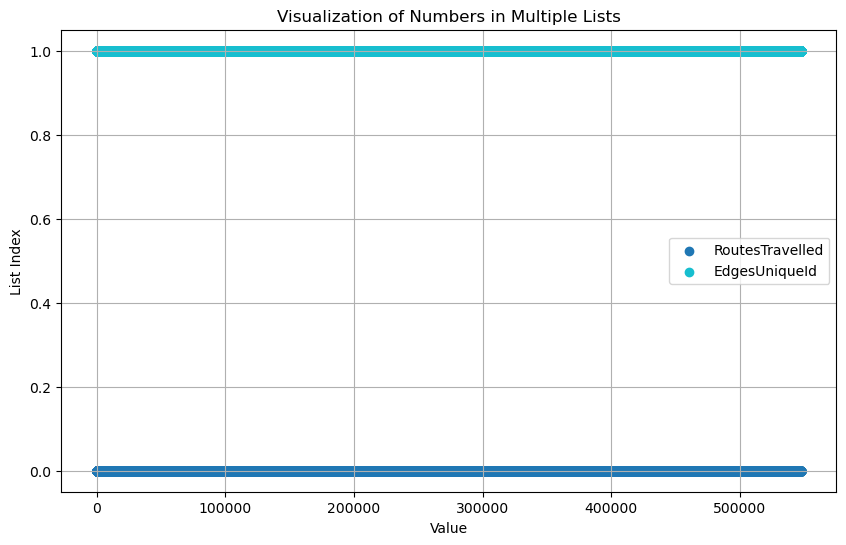

In [ ]:
import matplotlib.pyplot as plt
def visualize_lists(lists_of_numbers,ListLabels):
    """
    Visualize the positions of numbers in multiple lists on a line.
    
    :param lists_of_numbers: List of lists of numbers.
    """
    plt.figure(figsize=(10, 6))
    
    # Define colors for each list
    colors = plt.get_cmap('tab10', len(lists_of_numbers))
    
    for i, numbers in enumerate(lists_of_numbers):
        y = np.full_like(numbers, i)  # Create a y-array with the same value for each list
        plt.scatter(numbers, y, color=colors(i), label=f'List {i+1}')
    
    plt.xlabel('Value')
    plt.ylabel('List Index')
    plt.title('Visualization of Numbers in Multiple Lists')
    plt.legend(ListLabels)
    plt.grid(True)
    plt.show()

RoutesTravelled = DfRoute.select(pl.col("route").unique())
EdgesUniqueId = Edges["uniqueid"].to_numpy()

list_of_numbers = [RoutesTravelled["route"],EdgesUniqueId]
ListLabels = ["RoutesTravelled","EdgesUniqueId"]
visualize_lists(list_of_numbers,ListLabels)

In [ ]:
t_start_control_group = 7*3600
t_end_control_group = 8*3600
DfRouteControlGroup = FilterDfPeopleControlGroup(t_start_control_group,t_end_control_group,DfRoute,"time_departure","last_time_simulated")
def ComputeGamma(DfRouteControlGroup):
    """
        @param DfRouteControlGroup: DataFrame with the routes of the people in the network
        @return Gamma: Gamma of the Traffic simulation considering just the people of the control group.
    """
    Lexe = DfRouteControlGroup.select(pl.col("length").sum().alias("Lexe"))
    Z = DfRouteControlGroup.select((pl.col("capacity")*pl.col("length")).sum().alias("Z"))
    return Lexe/Z
Lexe = DfRouteControlGroup.select(pl.col("length").sum().alias("Lexe"))
Z = DfRouteControlGroup.select((pl.col("capacity")*pl.col("length")).sum().alias("Z"))

#Gamma = ComputeGamma(DfRouteControlGroup)
    

In [ ]:
Lexe["Lexe"]/Z["Z"]

Z
f64
0.0


# Capacity And Heterogeneous Hp

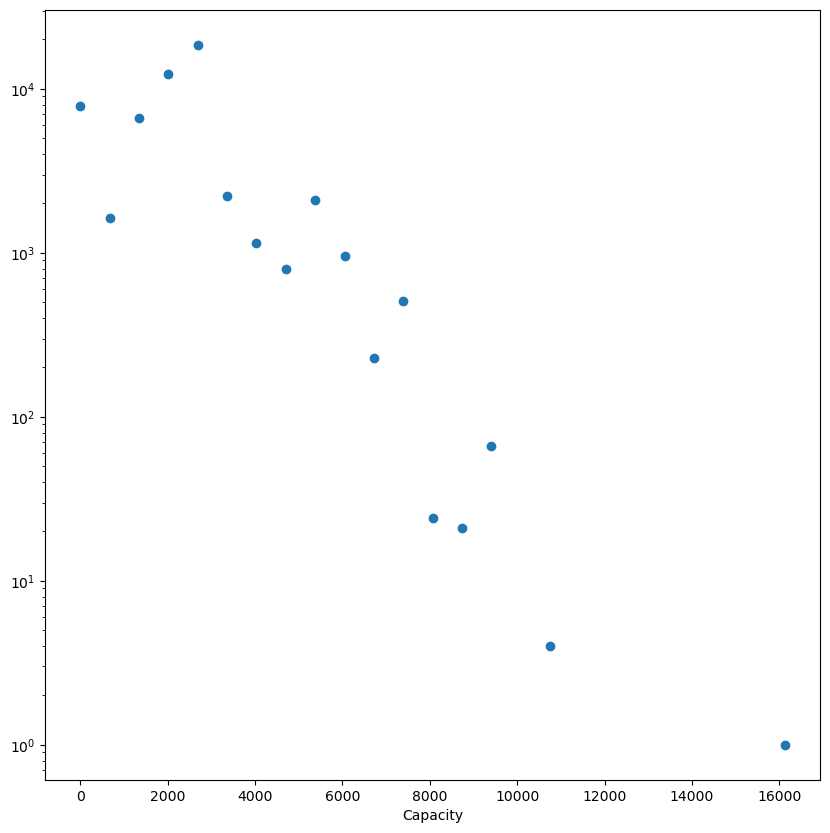

In [16]:
import matplotlib.pyplot as plt
n,bins = np.histogram(GeoJsonEdges["capacity"].to_numpy(),bins = 25)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.scatter(bins[:-1],n)
ax.set_xlabel('Capacity')
ax.set_yscale('log')
plt.show()

In [3]:
IntTimeArray = np.linspace(0,3600*24,96,dtype = int)

t = 30
DfRoute = DfRoute.with_columns(
    pl.lit(0).alias(f"flux_{t}")
)
DfRoute = DfRoute.with_columns(
    pl.lit(0.).alias(f"speed_kmh_{t}")
)
UsersPerAvgSpeedRoads = (pl.col("time_departure") <= IntTimeArray[t]) & (pl.col("last_time_simulated") >= IntTimeArray[t])
ComputedFluxesSpeed = DfRoute.filter(UsersPerAvgSpeedRoads).group_by("route").agg([
    (pl.col("avg_v(km/h)")).mean().alias(f"speed_kmh_{t}"),
    pl.col("p").count().alias(f"flux_{t}")
])
ComputedFluxesSpeed = ComputedFluxesSpeed.group_by("route").agg([pl.col(f"speed_kmh_{t}").mean().alias(f"speed_kmh_{t}")])
ComputedFluxesSpeed
#GeoJsonEdges = GeoJsonEdges.join(ComputedFluxesSpeed, on="route", how="left")
'''

for t in range(len(IntTimeArray)):
#    DfRoute.drop(f"flux_{t}")
#    DfRoute.drop(f"speed_kmh_{t}")
    DfRoute = DfRoute.with_columns(
        pl.lit(0).alias(f"flux_{t}")
    )
    DfRoute = DfRoute.with_columns(
        pl.lit(0.).alias(f"speed_kmh_{t}")
    )

for t in range(len(IntTimeArray)):
    print(t)
    UsersPerAvgSpeedRoads = (pl.col("time_departure") <= IntTimeArray[t]) & (pl.col("last_time_simulated") >= IntTimeArray[t])
    ComputedFluxesSpeed = DfRoute.filter(UsersPerAvgSpeedRoads).group_by("route").agg([
        (pl.col("avg_v(km/h)")).mean().alias(f"speed_kmh_{t}"),
        pl.col("p").count().alias(f"flux_{t}")
    ])
    ComputedFluxesSpeed = ComputedFluxesSpeed.group_by("route").agg([pl.col(f"speed_kmh_{t}").mean().alias(f"speed_kmh_{t}")])
    GeoJsonEdges = GeoJsonEdges.join(ComputedFluxesSpeed, on="route", how="left")
    DfRoute = DfRoute.join(ComputedFluxesSpeed[["route",f"speed_kmh_{t}",f"flux_{t}"]], on="route", how="left")
    DfRoute.drop([f"flux_{t}",f"speed_kmh_{t}"])
    DfRoute = DfRoute.with_columns(pl.col(f"flux_{t}_right").alias(f"flux_{t}"),
                     pl.col(f"speed_kmh_{t}_right").alias(f"speed_kmh_{t}"))

R = 220
UCI = 0.216
DfRoute.write_parquet(f"/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_{R}_UCI_{UCI}_traffic.parquet")
#        DfRoute = DfRoute.with_columns(pl.when(UsersPerAvgSpeedRoads).then(pl.col("avg_v(km/h)").mean()).alias(f"speed_kmh_{t}"))
#        DfRoute = DfRoute.with_columns(pl.when(UsersPerAvgSpeedRoads).then(pl.col("p").count()).alias(f"flux_{t}"))
'''

'\n\nfor t in range(len(IntTimeArray)):\n#    DfRoute.drop(f"flux_{t}")\n#    DfRoute.drop(f"speed_kmh_{t}")\n    DfRoute = DfRoute.with_columns(\n        pl.lit(0).alias(f"flux_{t}")\n    )\n    DfRoute = DfRoute.with_columns(\n        pl.lit(0.).alias(f"speed_kmh_{t}")\n    )\n\nfor t in range(len(IntTimeArray)):\n    print(t)\n    UsersPerAvgSpeedRoads = (pl.col("time_departure") <= IntTimeArray[t]) & (pl.col("last_time_simulated") >= IntTimeArray[t])\n    ComputedFluxesSpeed = DfRoute.filter(UsersPerAvgSpeedRoads).group_by("route").agg([\n        (pl.col("avg_v(km/h)")).mean().alias(f"speed_kmh_{t}"),\n        pl.col("p").count().alias(f"flux_{t}")\n    ])\n    ComputedFluxesSpeed = ComputedFluxesSpeed.group_by("route").agg([pl.col(f"speed_kmh_{t}").mean().alias(f"speed_kmh_{t}")])\n    GeoJsonEdges = GeoJsonEdges.join(ComputedFluxesSpeed, on="route", how="left")\n    DfRoute = DfRoute.join(ComputedFluxesSpeed[["route",f"speed_kmh_{t}",f"flux_{t}"]], on="route", how="left")\n    Df

In [4]:
ComputedFluxesSpeed

route,speed_kmh_30
i64,f64
286019,3.460699
349986,18.833012
329672,5.967875
332158,0.401347
372530,5.896146
…,…
289026,0.328586
289029,8.32154
314848,2.588185


SchemaError: invalid series dtype: expected `List`, got `i64`

In [ ]:
R = 220
UCI = 0.216
DfRoute = pl.read_parquet(f"/home/alberto/LPSim/LivingCity/berkeley_2018/BOS/Output/R_{R}_UCI_{UCI}_traffic.parquet")

In [ ]:
DfRoute

p,distance,route,time_departure,num_steps,active,last_time_simulated,avg_v(km/h),flux_30,speed_kmh_30
i64,f64,i64,f64,i64,i64,i64,f64,i32,f64
649897,12809.1,288271,25200.0,1754,2,26953,26.41136,0,0.0
649897,12809.1,352104,25200.0,1754,2,26953,26.41136,0,0.0
649897,12809.1,313490,25200.0,1754,2,26953,26.41136,0,0.0
649897,12809.1,292405,25200.0,1754,2,26953,26.41136,0,0.0
649897,12809.1,369789,25200.0,1754,2,26953,26.41136,0,0.0
…,…,…,…,…,…,…,…,…,…
7092071,4370.59,474981,86386.8,14,1,86400,12.116976,0,0.0
7092071,4370.59,399037,86386.8,14,1,86400,12.116976,0,0.0
7092071,4370.59,314547,86386.8,14,1,86400,12.116976,0,0.0


# Extract Fluxes Roads and Average Speed

In [ ]:
from PolarsFunctions import *
import tqdm

IntTimeArray = np.linspace(0,3600*24,96,dtype = int)
for t in range(len(IntTimeArray)):
    DfPeopleInNet = FilterDfPeopleStilInNet(IntTimeArray[t],IntTimeArray[t+1],"last_time_simulated",DfPeople)
    for User in tqdm(DfPeopleInNet["p"].to_numpy()):
        DfUser = DfPeopleInNet.filter(pl.col("p") == User)
        SpeedRoutesUserKmh = DfUser.with_columns(pl.col("avg_v(mph)")*1.6)["avg_v(mph)"].item()
        print(SpeedRoutesUserKmh)
        DfRoute =  update_flux_column(DfRoute,t,User,SpeedRoutesUserKmh)      

    

In [ ]:
def update_speed_column(df_route, df_people, t):
    column_name = f"speed_kmh_{t}"
    df_route = df_route.join(df_people, on="p", how="left")
    df_route = df_route.with_columns(
        pl.when(pl.col("avg_v(mph)").is_not_null()).then(pl.col("avg_v(mph)") * 1.6).otherwise(pl.col(column_name)).alias(column_name)
    )
    df_route = df_route.drop("avg_v(mph)")
    return df_route
for t in range(len(IntTimeArray)-1):
    DfPeopleInNet = FilterDfPeopleStilInNet(IntTimeArray[t],IntTimeArray[t+1],"last_time_simulated",DfPeople)
    DfRoute = update_speed_column(DfRoute, DfPeopleInNet, t)        
    


0


1


DuplicateError: unable to hstack, column with name "distance_right" already exists

In [ ]:
for t in range(len(IntTimeArray)):
#    DfRoute.drop(f"flux_{t}")
#    DfRoute.drop(f"speed_kmh_{t}")
    DfRoute = DfRoute.with_columns(
        pl.lit(0).alias(f"flux_{t}")
    )
    DfRoute = DfRoute.with_columns(
        pl.lit(0).alias(f"speed_kmh_{t}")
    )
    
def update_flux_column(df, t, user, new_value):
    column_name = f"flux_{t}"
    df = df.with_columns(
        pl.when(pl.col("p") == user).then(new_value).otherwise(pl.col(column_name)).alias(column_name)
    )
    return df


In [ ]:
DfRoute

p,distance,route,flux_0,speed_kmh_0,flux_1,speed_kmh_1,flux_2,speed_kmh_2,flux_3,speed_kmh_3,flux_4,speed_kmh_4,flux_5,speed_kmh_5,flux_6,speed_kmh_6,flux_7,speed_kmh_7,flux_8,speed_kmh_8,flux_9,speed_kmh_9,flux_10,speed_kmh_10,flux_11,speed_kmh_11,flux_12,speed_kmh_12,flux_13,speed_kmh_13,flux_14,speed_kmh_14,flux_15,speed_kmh_15,flux_16,speed_kmh_16,…,speed_kmh_84,flux_85,speed_kmh_85,flux_86,speed_kmh_86,flux_87,speed_kmh_87,flux_88,speed_kmh_88,flux_89,speed_kmh_89,flux_90,speed_kmh_90,flux_91,speed_kmh_91,flux_92,speed_kmh_92,flux_93,speed_kmh_93,flux_94,speed_kmh_94,flux_95,speed_kmh_95,init_intersection,end_intersection,time_departure,num_steps,co,gas,distance_right,a,b,T,active,last_time_simulated,path_length_cpu,path_length_gpu
i64,f64,i64,i32,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,f64,i64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64
649897,12809.1,288271,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
649897,12809.1,352104,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
649897,12809.1,313490,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
649897,12809.1,292405,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
649897,12809.1,369789,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
7007106,29772.2,350316,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
7007106,29772.2,12392,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null
7007106,29772.2,347608,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [ ]:
def MapEdgeIntoGeoJsonEdges(GeoJsonEdges,Edges):
    '''
        Maps the edges dataframe into the GeoJsonEdges dataframe
    '''
    Edges = Edges.rename(columns = {"uniqueid":"uniqueid_edge"})
    GeoJsonEdges = GeoJsonEdges.merge(Edges,how = 'left',left_on = 'uniqueid',right_on = 'uniqueid_edge')
    return GeoJsonEdges

In [ ]:
def MapFluxesToRoads(DfPeople,DfRoute,GeoJsonEdges):
    '''
        Maps the fluxes to the roads in the graph
    '''
    DfPeople = DfPeople.join(DfRoute,left_on = "p",right_on = "p",how = "inner")
    return DfPeople

yes


In [ ]:
max(DfRoute["route"].to_numpy()) # min = 45, max = 547696

547696

In [ ]:
max(GeoJsonEdges["osmid"].to_numpy())

TypeError: '>' not supported between instances of 'list' and 'int'

In [ ]:
Edges 

,uniqueid,u,v,length,speed_mph,lanes,osmid_u,osmid_v
0,0,0,9,51.8,35,1,61816807,61819222
1,1,0,3,55.4,25,1,61816807,61817409
2,2,0,6,2223.4,35,1,61816807,61818775
3,3,1,10,1116.2,35,1,61817002,61819564
4,4,1,9,30.0,35,1,61817002,61819222
...,...,...,...,...,...,...,...,...
54946,54946,23464,23463,15.6,20,1,10281222833,10281222831
54947,54947,23465,23463,105.5,20,1,10281222839,10281222831
54948,54948,23466,23186,16.9,25,1,10844948681,72474574
54949,54949,23466,23165,95.0,50,1,10844948681,72330377
